In [1]:
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from transformers import BartForConditionalGeneration, AutoTokenizer
import copy
import matplotlib.pylab as plt

In [2]:
model_checkpoint = "Salesforce/bart-large-xsum-samsum"
batch_size = 2
epochs = 4

In [3]:
torch.cuda.is_available()

True

In [4]:
!nvidia-smi

Thu Mar 17 11:55:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-PCIE-40GB      Off  | 00000000:01:00.0 Off |                    0 |
| N/A   32C    P0    39W / 250W |   8282MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-PCIE-40GB      Off  | 00000000:41:00.0 Off |                    0 |
| N/A   

In [5]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=4)

In [6]:
# define the function
def shift_tokens_right(input_ids: torch.Tensor, pad_token_id: int, decoder_start_token_id: int):
    """
    Shift input ids one token to the right.
    """
    shifted_input_ids = input_ids.new_zeros(input_ids.shape)
    shifted_input_ids[:, 1:] = input_ids[:, :-1].clone()
    shifted_input_ids[:, 0] = decoder_start_token_id

    if pad_token_id is None:
        raise ValueError("self.model.config.pad_token_id has to be defined.")
    # replace possible -100 values in labels by `pad_token_id`
    shifted_input_ids.masked_fill_(shifted_input_ids == -100, pad_token_id)

    return shifted_input_ids


# define the class
class MLT(nn.Module):
    
    def __init__(self, model_checkpoint):
      super(MLT, self).__init__()

      self.model = BartForConditionalGeneration.from_pretrained(model_checkpoint)
      self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

      self.encoder = self.model.get_encoder()

      self.decoder1 = self.model.get_decoder()
      self.decoder2 = copy.deepcopy(self.decoder1)

      self.lm_head1 = self.model.get_output_embeddings()
      self.lm_head2 = copy.deepcopy(self.lm_head1)

    def get_config(self):
      return self.model.config

    def get_decoder(self):
      return self.decoder1

    def get_lm_head(self):
      return self.lm_head1

    def get_final_logits_bias(self):
      return self.model.final_logits_bias

    def get_tokenizer(self):
      return self.tokenizer

    def forward(self, text, summary1, summary2):
      # inputs = self.tokenizer.encode(text, return_tensors="pt")
      # target1 = self.tokenizer.encode(summary1, return_tensors="pt")
      # target2 = self.tokenizer.encode(summary2, return_tensors="pt")

      inputs = text
      target1 = summary1
      target2 = summary2

      encoder_outputs = self.encoder(inputs)

      decoder_input_ids1 = shift_tokens_right(
                    target1, self.model.config.pad_token_id, self.model.config.decoder_start_token_id
                )
      
      decoder_input_ids2 = shift_tokens_right(
                    target2, self.model.config.pad_token_id, self.model.config.decoder_start_token_id
                )
      
      
      decoder_outputs1 = self.decoder1(
          decoder_input_ids1, 
          encoder_hidden_states=encoder_outputs[0], 
          use_cache = False,
          output_attentions=self.model.config.output_attentions,
          output_hidden_states=self.model.config.output_hidden_states,
          return_dict=self.model.config.use_return_dict,
          ) 

      decoder_outputs2 = self.decoder2(
          decoder_input_ids2, 
          encoder_hidden_states=encoder_outputs[0], 
          use_cache = False,
          output_attentions=self.model.config.output_attentions,
          output_hidden_states=self.model.config.output_hidden_states,
          return_dict=self.model.config.use_return_dict,
          )  

      lm_logits1 = self.lm_head1(decoder_outputs1[0]) + self.model.final_logits_bias
      lm_logits2 = self.lm_head2(decoder_outputs2[0]) + self.model.final_logits_bias   

      masked_lm_loss1 = None
      masked_lm_loss2 = None
      loss_fct = CrossEntropyLoss()
      masked_lm_loss1 = loss_fct(lm_logits1.view(-1, self.model.config.vocab_size), target1.view(-1))
      masked_lm_loss2 = loss_fct(lm_logits2.view(-1, self.model.config.vocab_size), target2.view(-1))
      
      # return {
      #     'loss1': masked_lm_loss1, 
      #     'loss2': masked_lm_loss2,
      #     'encoder_outputs': encoder_outputs
      #     }

      return (masked_lm_loss1, masked_lm_loss2, encoder_outputs)


# create the object
model = MLT(model_checkpoint)

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [7]:
model.to(device)

MLT(
  (model): BartForConditionalGeneration(
    (model): BartModel(
      (shared): Embedding(50264, 1024, padding_idx=1)
      (encoder): BartEncoder(
        (embed_tokens): Embedding(50264, 1024, padding_idx=1)
        (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
        (layers): ModuleList(
          (0): BartEncoderLayer(
            (self_attn): BartAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
            (final_layer_norm): LayerNor

In [8]:
from pathlib import Path

transcripts_dir = Path("./data/ami/transcripts")
abs_summaries_dir = Path("./data/ami/summaries/abstractive")
ext_summaries_dir = Path("./data/ami/summaries/extractive")

transcripts = []
abs_summaries = []
ext_summaries = []

for file in transcripts_dir.iterdir():
  transcripts.append(file.read_text())

for file in abs_summaries_dir.iterdir():
  abs_summaries.append(file.read_text())

for file in ext_summaries_dir.iterdir():
  ext_summaries.append(file.read_text())

print(len(transcripts))
print(len(abs_summaries))
print(len(ext_summaries))

137
137
137


In [9]:
from sklearn.model_selection import train_test_split

train_transcripts, val_transcripts, train_abs_summaries, val_abs_summaries = train_test_split(transcripts, abs_summaries, test_size=.2)
_, _, train_ext_summaries, val_ext_summaries = train_test_split(transcripts, ext_summaries, test_size=.2)

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_transcripts_encodings = tokenizer(train_transcripts, truncation=True, padding=True)
val_transcripts_encodings = tokenizer(val_transcripts, truncation=True, padding=True)

with tokenizer.as_target_tokenizer():
  train_abs_summaries_encodings = tokenizer(train_abs_summaries, truncation=True, padding=True)
  val_abs_summaries_encodings = tokenizer(val_abs_summaries, truncation=True, padding=True)

  train_ext_summaries_encodings = tokenizer(train_ext_summaries, truncation=True, padding=True)
  val_ext_summaries_encodings = tokenizer(val_ext_summaries, truncation=True, padding=True)

In [11]:
class MeetDataset(torch.utils.data.Dataset):
    def __init__(self, transcripts, abs_summaries, ext_summaries):
        self.transcripts = transcripts
        self.abs_summaries = abs_summaries
        self.ext_summaries = ext_summaries

    def __len__(self):
        return len(self.transcripts.input_ids)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.transcripts.items()}
        item["abs"] = torch.tensor(self.abs_summaries["input_ids"][idx])
        item["ext"] = torch.tensor(self.ext_summaries["input_ids"][idx])
        return item

    

train_dataset = MeetDataset(train_transcripts_encodings, train_abs_summaries_encodings, train_ext_summaries_encodings)
val_dataset = MeetDataset(val_transcripts_encodings, val_abs_summaries_encodings, val_ext_summaries_encodings)

In [12]:
train_dataset.__len__(), val_dataset.__len__()

(109, 28)

In [13]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
from transformers import BartPretrainedModel
from transformers.modeling_outputs import Seq2SeqLMOutput

class DecoderForGeneration(BartPretrainedModel):

    def __init__(self, config, decoder, lm_head, final_logits_bias):
        super().__init__(config)
        
        self.config = config
        self.decoder = decoder
        self.lm_head = lm_head
        self.final_logits_bias = final_logits_bias

    # def get_encoder(self):
    #     return self.get_encoder()

    def get_decoder(self):
        return self.model.get_decoder()

    def resize_token_embeddings(self, new_num_tokens: int) -> nn.Embedding:
        new_embeddings = super().resize_token_embeddings(new_num_tokens)
        self._resize_final_logits_bias(new_num_tokens)
        return new_embeddings

    def _resize_final_logits_bias(self, new_num_tokens: int) -> None:
        old_num_tokens = self.final_logits_bias.shape[-1]
        if new_num_tokens <= old_num_tokens:
            new_bias = self.final_logits_bias[:, :new_num_tokens]
        else:
            extra_bias = torch.zeros((1, new_num_tokens - old_num_tokens), device=self.final_logits_bias.device)
            new_bias = torch.cat([self.final_logits_bias, extra_bias], dim=1)
        self.register_buffer("final_logits_bias", new_bias)

    def get_output_embeddings(self):
        return self.lm_head

    def set_output_embeddings(self, new_embeddings):
        self.lm_head = new_embeddings

    
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        head_mask=None,
        decoder_head_mask=None,
        cross_attn_head_mask=None,
        encoder_outputs=None,
        past_key_values=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the masked language modeling loss. Indices should either be in `[0, ...,
            config.vocab_size]` or -100 (see `input_ids` docstring). Tokens with indices set to `-100` are ignored
            (masked), the loss is only computed for the tokens with labels in `[0, ..., config.vocab_size]`.

        Returns:
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if labels is not None:
            # if use_cache:
            #     logger.warning("The `use_cache` argument is changed to `False` since `labels` is provided.")
            use_cache = False
            if decoder_input_ids is None and decoder_inputs_embeds is None:
                decoder_input_ids = shift_tokens_right(
                    labels, self.config.pad_token_id, self.config.decoder_start_token_id
                )

        decoder_outputs = self.decoder(
        decoder_input_ids, 
        encoder_hidden_states=encoder_outputs[0], 
        use_cache = False,
        output_attentions=self.config.output_attentions,
        output_hidden_states=self.config.output_hidden_states,
        return_dict=self.config.use_return_dict,
        )
        lm_logits = self.lm_head(decoder_outputs[0]) + self.final_logits_bias

        masked_lm_loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            masked_lm_loss = loss_fct(lm_logits.view(-1, model.config.vocab_size), labels.view(-1))

        if not return_dict:
            output = (lm_logits,) + decoder_outputs[1:]
            return ((masked_lm_loss,) + output) if masked_lm_loss is not None else output

        return Seq2SeqLMOutput(
            loss=masked_lm_loss,
            logits=lm_logits,
            past_key_values=decoder_outputs.past_key_values,
            decoder_hidden_states=decoder_outputs.hidden_states,
            decoder_attentions=decoder_outputs.attentions,
            cross_attentions=decoder_outputs.cross_attentions,
            encoder_last_hidden_state=encoder_outputs.last_hidden_state,
            encoder_hidden_states=encoder_outputs.hidden_states,
            encoder_attentions=encoder_outputs.attentions,
        )

    def prepare_inputs_for_generation(
        self,
        decoder_input_ids,
        past=None,
        attention_mask=None,
        head_mask=None,
        decoder_head_mask=None,
        cross_attn_head_mask=None,
        use_cache=None,
        encoder_outputs=None,
        **kwargs
    ):
        # cut decoder_input_ids if past is used
        if past is not None:
            decoder_input_ids = decoder_input_ids[:, -1:]

        return {
            "input_ids": None,  # encoder_outputs is defined. input_ids not needed
            "encoder_outputs": encoder_outputs,
            "past_key_values": past,
            "decoder_input_ids": decoder_input_ids,
            "attention_mask": attention_mask,
            "head_mask": head_mask,
            "decoder_head_mask": decoder_head_mask,
            "cross_attn_head_mask": cross_attn_head_mask,
            "use_cache": use_cache,  # change this to avoid caching (presumably for debugging)
        }

    def prepare_decoder_input_ids_from_labels(self, labels: torch.Tensor):
        return shift_tokens_right(labels, self.config.pad_token_id, self.config.decoder_start_token_id)

    @staticmethod
    def _reorder_cache(past, beam_idx):
        reordered_past = ()
        for layer_past in past:
            # cached cross_attention states don't have to be reordered -> they are always the same
            reordered_past += (
                tuple(past_state.index_select(0, beam_idx) for past_state in layer_past[:2]) + layer_past[2:],
            )
        return reordered_past


myDecoderModel = DecoderForGeneration(model.get_config(), model.get_decoder(), model.get_lm_head(), model.get_final_logits_bias())

In [15]:
myDecoderModel.to(device)

DecoderForGeneration(
  (decoder): BartDecoder(
    (embed_tokens): Embedding(50264, 1024, padding_idx=1)
    (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
    (layers): ModuleList(
      (0): BartDecoderLayer(
        (self_attn): BartAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder_attn): BartAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=Tru

In [16]:
from datasets import load_metric

metric = load_metric("rouge")

In [17]:
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [18]:
import numpy as np
import nltk
nltk.download('punkt')
def train(model, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss': [], 'validation_loss': []}  
    
    for epoch in range(epochs):
        print(epoch)
        # model.train()
        for i, data in enumerate(train_loader):
            data['input_ids'], data['abs'], data['ext'] = data['input_ids'].to(device), data['abs'].to(device), data['ext'].to(device)
            optimizer.zero_grad()
            output = model(data['input_ids'], data['abs'], data['ext'])
            loss = output[0] + output[1]
            loss.backward()
            optimizer.step()
            useful_stuff['training_loss'].append(loss.item())
            print(loss.item())

        print("Validation")
        model.eval()
        for i, data in enumerate(validation_loader):
            with torch.no_grad():
              data['input_ids'], data['abs'], data['ext'] = data['input_ids'].to(device), data['abs'].to(device), data['ext'].to(device)
              output = model(data['input_ids'], data['abs'], data['ext'])
              loss = output[0] + output[1]
              useful_stuff['validation_loss'].append(loss.item())
              print(loss.item())

              predictions = myDecoderModel.generate(data['input_ids'], encoder_outputs=output[2])
              labels = data['abs'].cpu()

              decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
              # Replace -100 in the labels as we can't decode them.
              labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
              decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
              
              # Rouge expects a newline after each sentence
              decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
              decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

              metric.add_batch(predictions=decoded_preds, references=decoded_labels)
              
        result = metric.compute(use_stemmer=True)
        # Extract a few results from ROUGE
        result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

        result = {k: round(v, 4) for k, v in result.items()}
    
    return (useful_stuff, result)

training_results = train(model, train_loader, validation_loader, optimizer, epochs=epochs)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/tanik_1821cs08/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0
20.407236099243164
20.91741180419922
19.326730728149414
13.819416046142578
15.221709251403809
113.82301330566406
42.41379165649414
36.88201141357422
23.679845809936523
32.55747985839844
22.87494468688965
24.70960807800293
20.782690048217773
16.786361694335938
20.710559844970703
18.690048217773438
20.832002639770508
18.475448608398438
20.586963653564453
17.85483169555664
17.8887939453125
12.992992401123047
13.194473266601562
16.16101837158203
13.92646598815918
13.530242919921875
14.297982215881348
12.240488052368164
11.271446228027344
10.515932083129883
11.679241180419922
12.46891975402832
29.043333053588867
22.743114471435547
28.89305877685547
21.56205177307129
25.87702178955078
28.243263244628906
22.933610916137695
20.903541564941406
22.183544158935547
20.71725082397461
26.7864990234375
20.727561950683594
20.701396942138672
21.568225860595703
16.752763748168945
23.17405891418457
20.962453842163086
21.237504959106445
20.861806869506836
16.13625144958496
34.065391540527344
17.69273757

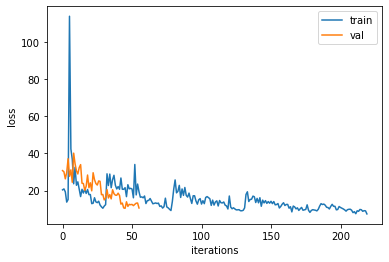

In [19]:
plt.plot(training_results[0]['training_loss'], label="train")
plt.plot(training_results[0]['validation_loss'], label="val")
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()
#plt.title('training loss iterations')

In [20]:
training_results[1]

{'rouge1': 16.9723, 'rouge2': 1.0236, 'rougeL': 10.9669, 'rougeLsum': 14.3002}

In [21]:
!nvidia-smi

Thu Mar 17 12:00:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-PCIE-40GB      Off  | 00000000:01:00.0 Off |                    0 |
| N/A   32C    P0    38W / 250W |   7581MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-PCIE-40GB      Off  | 00000000:41:00.0 Off |                    0 |
| N/A   

In [22]:
import pickle
with open('Salesforce-bart-large-xsum-samsum.pickle', 'wb') as f:
    pickle.dump(training_results, f)